In [1]:
''' Test model '''

' Test model '

In [1]:
import torch
job_num="108"
fp=f"/Volumes/LaCie/june7/model_job{job_num}/losses.pth"
checkpoint = torch.load(fp, map_location=torch.device('cpu'))
train_losses=checkpoint['train_losses']
valid_losses=checkpoint['valid_losses']
train_precision=checkpoint['train_precision']
valid_precision=checkpoint['valid_precision']
train_recall=checkpoint['train_recall']
valid_recall=checkpoint['valid_recall']
train_tp=checkpoint['train_tp']
train_fn=checkpoint['train_fn']
train_fp=checkpoint['train_fp']
train_tn=checkpoint['train_tn']
valid_tp=checkpoint['valid_tp']
valid_fn=checkpoint['valid_fn']
valid_fp=checkpoint['valid_fp']
valid_tn=checkpoint['valid_tn']

In [2]:
print(train_precision[0])
print(train_precision[-1])

tensor(0.7880)
tensor(0.0049)


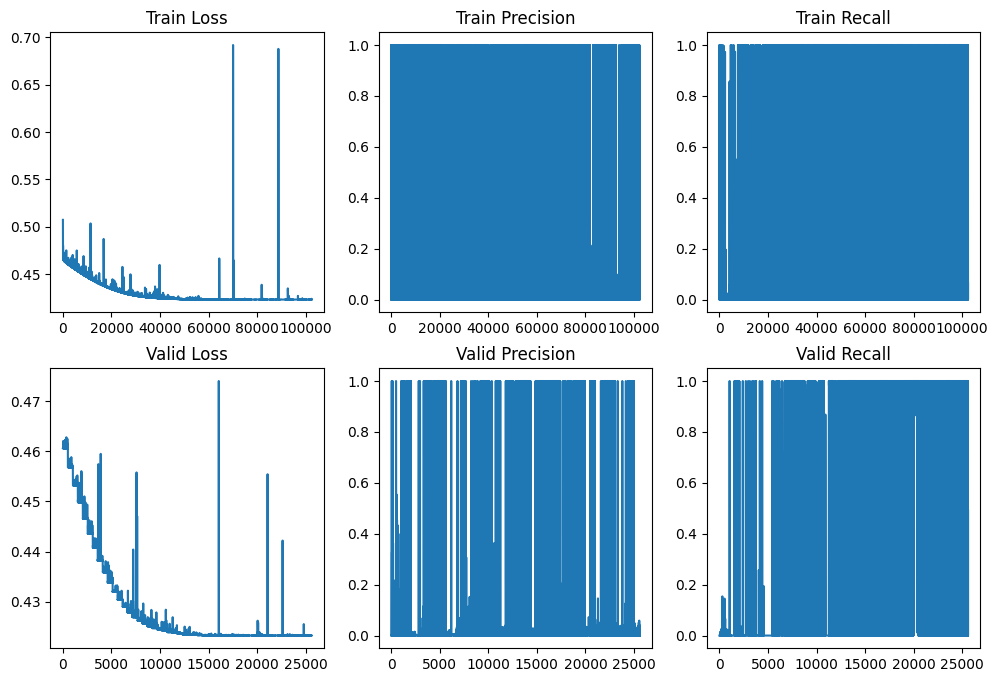

In [3]:
import matplotlib.pyplot as plt
fig, ax= plt.subplots(2,3,figsize=(12, 8))
ax[0,0].set_title("Train Loss")
ax[0,0].plot(train_losses)
ax[1,0].set_title("Valid Loss")
ax[1,0].plot(valid_losses)
ax[0,1].set_title("Train Precision")
ax[0,1].plot(train_precision)
ax[1,1].set_title("Valid Precision")
ax[1,1].plot(valid_precision)
ax[0,2].set_title("Train Recall")
ax[0,2].plot(train_recall)
ax[1,2].set_title("Valid Recall")
ax[1,2].plot(valid_recall)
plt.show()

Text(0.5, 1.0, 'Validation False Negatives')

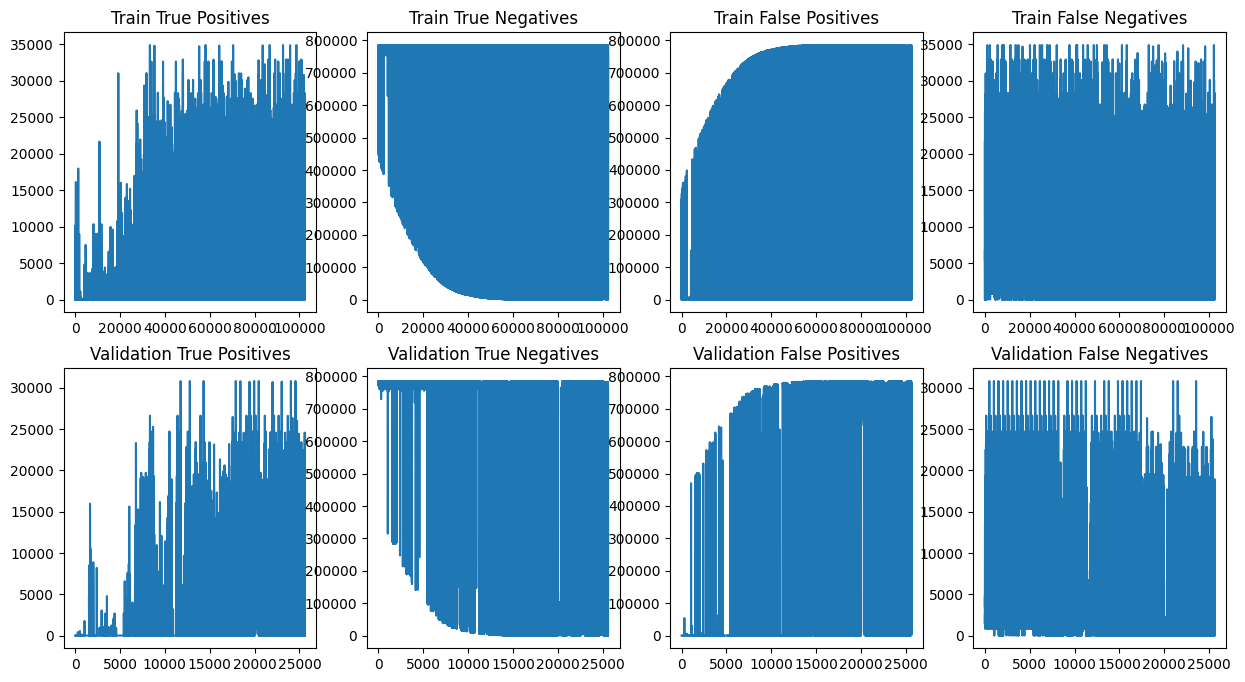

In [4]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,4, figsize=(15,8))
ax[0, 0].plot(train_tp)
ax[0, 0].set_title('Train True Positives')
ax[0, 1].plot(train_tn)
ax[0, 1].set_title('Train True Negatives')
ax[0, 2].plot(train_fp)
ax[0, 2].set_title('Train False Positives')
ax[0, 3].plot(train_fn)
ax[0, 3].set_title('Train False Negatives')

# Plotting validation data
ax[1, 0].plot(valid_tp)
ax[1, 0].set_title('Validation True Positives')
ax[1, 1].plot(valid_tn)
ax[1, 1].set_title('Validation True Negatives')
ax[1, 2].plot(valid_fp)
ax[1, 2].set_title('Validation False Positives')
ax[1, 3].plot(valid_fn)
ax[1, 3].set_title('Validation False Negatives')


In [7]:
# read images and masks (3D grayscale images)
import numpy as np
import torchio as tio
fp = "/Volumes/LaCie/512_depth_5/original/z0_y11_x12.npy"
mask_fp = "/Volumes/LaCie/512_depth_5/ground_truth/z0_y11_x12.npy"
image = np.load(fp) # each pixel is 0-255, shape (depth, height, width)
mask = np.load(mask_fp) # each pixel is 0 or 1, shape (depth, height, width)

# convert to tensor
image = torch.tensor(image).float().unsqueeze(0) # add channel dimension (depth, height, width) --> (1, depth, height, width)
mask = torch.tensor(mask).float().unsqueeze(0) # add channel dimension (depth, height, width) --> (1, depth, height, width)
mask[mask!=0]=1
image = tio.ZNormalization()(image)
print(image.shape, mask.shape)

/Users/huayinluo/Documents/code/gapjncsegmentation/gapvenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([1, 5, 512, 512]) torch.Size([1, 5, 512, 512])


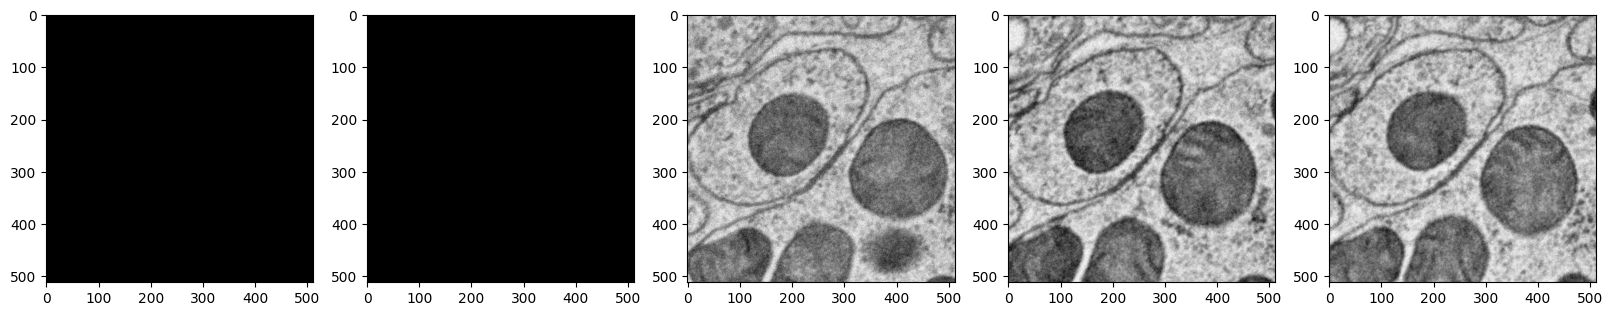

In [9]:
from utilities import *
fig, ax = plt.subplots(1, 5)
visualize_3d_slice(image[0], ax)

In [14]:
# Apply the flip transformation to the subject
subject = tio.Subject(
    image=tio.ScalarImage(tensor=image),
    mask=tio.LabelMap(tensor=mask)
)
flip_transform = tio.RandomFlip(axes=0, flip_probability=1)
flipped_subject = flip_transform(subject)
print(flipped_subject.image.shape)
fig, ax = plt.subplots(1, 5)
tmp = flipped_subject.image.tensor
print(tmp.shape)
visualize_3d_slice(tmp[0], ax)

(1, 5, 512, 512)


torch.Size([1, 5, 512, 512]) torch.Size([1, 5, 512, 512]) torch.Size([2, 5, 512, 512])


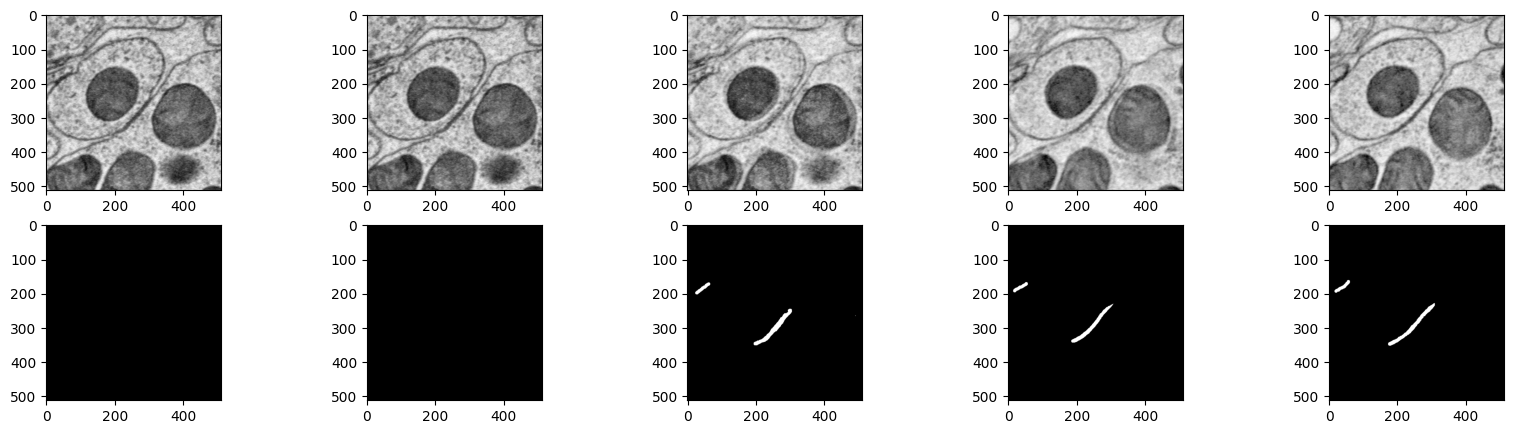

In [30]:
# Apply the flip transformation to the subject
subject = tio.Subject(
    image=tio.ScalarImage(tensor=image),
    mask=tio.LabelMap(tensor=mask)
)
flip_transform = tio.RandomFlip(axes=1, flip_probability=0.5)
flipped_subject = flip_transform(subject)
flip_transform = tio.RandomFlip(axes=1, flip_probability=0.5)
flipped_subject = flip_transform(flipped_subject)
flip_transform = tio.RandomFlip(axes=2, flip_probability=0.5)
flipped_subject = flip_transform(flipped_subject)
flipped_image = flipped_subject.image.tensor
additional_transforms = tio.Compose([
    tio.RandomBlur(p=0.5),
    tio.RandomNoise(p=0.5),
    tio.RandomGamma(p=0.5)
])


# Apply the additional transformations to the flipped image
flipped_image = additional_transforms(flipped_image)
flipped_mask = flipped_subject.mask.tensor
fig, ax = plt.subplots(2, 5)
visualize_3d_slice(flipped_image[0], ax[0])
visualize_3d_slice(flipped_mask[0], ax[1])
one_hot_mask = torch.nn.functional.one_hot(flipped_mask.squeeze(0).long(), num_classes=2)
one_hot_mask = one_hot_mask.permute(3, 0, 1, 2).float() # (num_classes, depth, height, width)
print(flipped_mask.shape, flipped_image.shape, one_hot_mask.shape)

In [ ]:

# apply augmentations, if any

    # Apply the flip transformation to the subject
    subject = tio.Subject(
        image=tio.ScalarImage(tensor=image),
        mask=tio.LabelMap(tensor=mask)
    )
    flip_transform = tio.RandomFlip(axes=0, flip_probability=0.5)
    flipped_subject = flip_transform(subject)
    flip_transform = tio.RandomFlip(axes=1, flip_probability=0.5)
    flipped_subject = flip_transform(flipped_subject)
    flip_transform = tio.RandomFlip(axes=2, flip_probability=0.5)
    flipped_subject = flip_transform(flipped_subject)
    image = flipped_subject.image.tensor
    mask = flipped_subject.mask.tensor

    # Define additional transformations for the image
    additional_transforms = tio.Compose([
        tio.RandomBlur(p=0.5),
        tio.RandomNoise(p=0.5),
        tio.RandomGamma(p=0.5)
    ])

    # Apply the additional transformations to the flipped image
    image = additional_transforms(image)
    
# one-hot encode the mask (depth, height, width) --> (depth, height, width, num_classes=2)
one_hot_mask = torch.nn.functional.one_hot(mask.squeeze(0).long(), num_classes=2)
one_hot_mask = one_hot_mask.permute(3, 0, 1, 2).float() # (num_classes, depth, height, width)
return image, one_hot_mask

In [1]:
import models
import utilities

# --- reload the modules
import importlib
importlib.reload(models)
importlib.reload(utilities)
# --- end of reload

from models import *
from utilities import *
model = UNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model_name = "model_job84"
epoch=49
fp=f"/Volumes/LaCie/models/{model_name}_epoch_{epoch}.pth"
# fp=f"/Users/huayinluo/Documents/code/gapjncsegmentation/models/{model_name}_epoch_{epoch}.pth"
# fp=f"/home/huayin/Documents/gapjncsegmentation/models/{model_name}_epoch_{epoch}.pth"
model, optimizer, epoch, loss, batch_size, lr, focal_loss_weights = load_checkpoint(model, optimizer, fp)
model = model.eval()

In [2]:
from dataset import SliceDataset
import numpy as np
import os
from dataset import *
from utilities_train import *

data_dir = "/Volumes/LaCie/select_dauer_data_256"
train_dataset, valid_dataset, train_loader, valid_loader = setup_datasets_and_dataloaders(data_dir, batch_size=1, num_workers=0)
results_dir = "results/dauer_data_256"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
print(len(train_dataset), len(valid_dataset))

/Users/huayinluo/Documents/code/gapjncsegmentation/gapvenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


13267 8192


In [3]:
k = 25
found_img = False
while not found_img:
    img, mask = train_dataset[k] # (label, depth, height, width)
    print(img.shape, mask.shape)
    depth = img.shape[1]
    if img.shape[2] != 256 or img.shape[3] != 256:
        k+=1
        continue
    else:
        print("k", k)
        found_img=True

torch.Size([1, 3, 62, 212]) torch.Size([2, 3, 62, 212])
torch.Size([1, 3, 256, 256]) torch.Size([2, 3, 256, 256])
k 26


In [2]:
# masks:
# z_indices = [101, 102, 103, 104, 105, 106, 107, 108, 109]
z_indices = [101, 102, 103]
width = 9360
height = 8328
depth = len(z_indices)

In [3]:
img_volume = np.zeros((depth, height, width))
mask_volume = np.zeros((depth, height, width))
print(img_volume.shape, mask_volume.shape)

(3, 8328, 9360) (3, 8328, 9360)


In [4]:
for i in range(depth):
    z = str(z_indices[i])
    mask_fp=f"/Volumes/LaCie/sem_dauer_2_gj_gt/sem_dauer_2_gj_gt_s{z}.png"
    mask = cv2.imread(mask_fp, cv2.COLOR_BGR2GRAY) # height, width, 3
    img_fp=f"/Volumes/LaCie/SEM_dauer_2_em/SEM_dauer_2_em_s{z}.png"
    img = cv2.imread(img_fp, cv2.COLOR_BGR2GRAY) # height, width, 3
    img_volume[i] = img
    mask_volume[i] = mask
    print(f"loaded {i}")

loaded 0
loaded 1
loaded 2


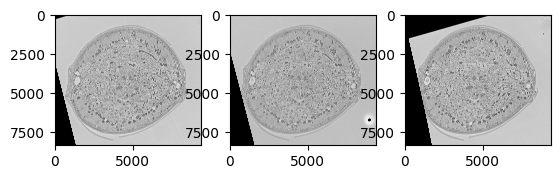

In [5]:
from utilities import *
fig, ax = plt.subplots(1, depth)
visualize_3d_slice(img_volume, ax)

In [6]:
img_volume_tmp = img_volume[:, 500:756, 500:756]
print(img_volume_tmp.shape)

(3, 256, 256)


In [16]:
# convert to tensor
import torchio as tio
image = torch.tensor(img_volume_tmp).float().unsqueeze(0) # add channel dimension (depth, height, width) --> (1, depth, height, width)
image = tio.ZNormalization()(image)

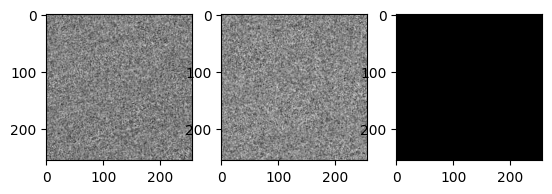

In [19]:
fig, ax = plt.subplots(1,3)
visualize_3d_slice(image[0], ax)

In [10]:
pred = model(image)
print(pred.shape)

AttributeError: 'tuple' object has no attribute 'shape'

In [11]:
_, pred_final = pred

In [20]:
pred_final = torch.argmax(pred_final[0], dim=0) # (depth, height, width)
print(pred_final.shape)

torch.Size([3, 256, 256])


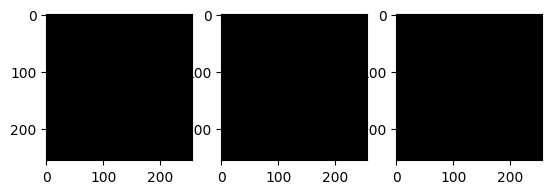

In [22]:
fig, ax = plt.subplots(1, depth)
visualize_3d_slice(pred_final.detach(), ax)

# Archive

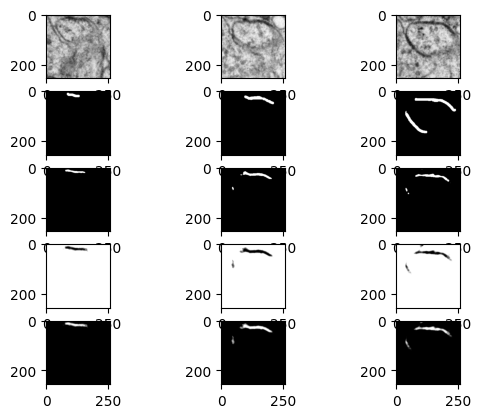

In [4]:
intermediate_pred, pred = model(img)
pred_max = torch.argmax(pred[0], dim=0) # (depth, height, width)
fig, ax = plt.subplots(5, depth)
visualize_3d_slice(img[0], ax[0])
visualize_3d_slice(mask[1], ax[1])
visualize_3d_slice(pred_max, ax[2])
visualize_3d_slice(pred[0,0].detach(), ax[3])
visualize_3d_slice(pred[0,1].detach(), ax[4])

In [5]:
expanded_mask = torch.nn.functional.pad(mask, (50, 50, 50, 50), mode='constant', value=0)
print(expanded_mask.shape)

torch.Size([2, 3, 356, 356])


In [6]:
import torch
import torch.nn.functional as F

import torch
import torch.nn.functional as F

def shrink_binary_mask_3d(mask, kernel_size=(3,3,3)):
    """
    Shrinks the 3D binary mask by eroding it by a padding of 1.
    
    Parameters:
    - mask: torch.Tensor of shape (D, H, W) containing binary values (0 and 1)
    
    Returns:
    - shrunk_mask: torch.Tensor of the same shape as mask with shrunk blobs
    """
    # Create a 3D structuring element (kernel)
    depth_kernel, height_kernel, width_kernel = kernel_size
    if depth_kernel % 2 == 0: depth_kernel += 1 # Ensure the kernel size is odd (if not, add 1)
    if height_kernel % 2 == 0: height_kernel += 1
    if width_kernel % 2 == 0: width_kernel += 1
    structuring_element = torch.ones((1, 1, depth_kernel, height_kernel, width_kernel), dtype=torch.float32)
    
    # Apply dilation on the inverted mask (equivalent to erosion on the original mask)
    inverted_mask = 1 - mask.unsqueeze(0).unsqueeze(0).float() # Invert the mask for erosion (1s become 0s and 0s become 1s)
    eroded_mask = F.conv3d(inverted_mask, structuring_element, padding=(depth_kernel//2, height_kernel//2, width_kernel//2))
    eroded_mask = (eroded_mask < structuring_element.sum()).float() # Threshold the result to obtain a binary mask again
    shrunk_mask = 1 - eroded_mask # Invert back to get the eroded original mask
    shrunk_mask = shrunk_mask.squeeze(0).squeeze(0) # Remove batch and channel dimensions
    
    return shrunk_mask

def expand_binary_mask_3d(mask, kernel_size=(3,3,3)):
    """
    Expands the 3D binary mask using morphological dilation.
    
    Parameters:
    - mask: torch.Tensor of shape (D, H, W) containing binary values (0 and 1)
    - kernel_size: (int,int, int) size of the structuring element (must be odd)
    
    Returns:
    - expanded_mask: torch.Tensor of the same shape as mask with expanded blobs
    """
    # Create a 3D structuring element (kernel)
    depth_kernel, height_kernel, width_kernel = kernel_size
    if depth_kernel % 2 == 0: depth_kernel += 1 # Ensure the kernel size is odd (if not, add 1)
    if height_kernel % 2 == 0: height_kernel += 1
    if width_kernel % 2 == 0: width_kernel += 1
    structuring_element = torch.ones((1, 1, depth_kernel, height_kernel, width_kernel), dtype=torch.float32)
    
    # Apply dilation using 3D convolution
    mask = mask.unsqueeze(0).unsqueeze(0).float() # Add batch and channel dimensions to the mask
    expanded_mask = F.conv3d(mask, structuring_element, padding=(depth_kernel//2, height_kernel//2, width_kernel//2))
    expanded_mask = (expanded_mask > 0).float() # Threshold the result to obtain a binary mask again
    expanded_mask = expanded_mask.squeeze(0).squeeze(0) # Remove batch and channel dimensions
    
    return expanded_mask

In [8]:
cutoff=0.9
pred_cutoff = pred[0, 1]
print(pred_cutoff.shape)
pred_cutoff[pred_cutoff > cutoff] = 1
pred_cutoff[pred_cutoff <= cutoff] = 0
pred_cutoff.shape

torch.Size([3, 256, 256])


torch.Size([3, 256, 256])

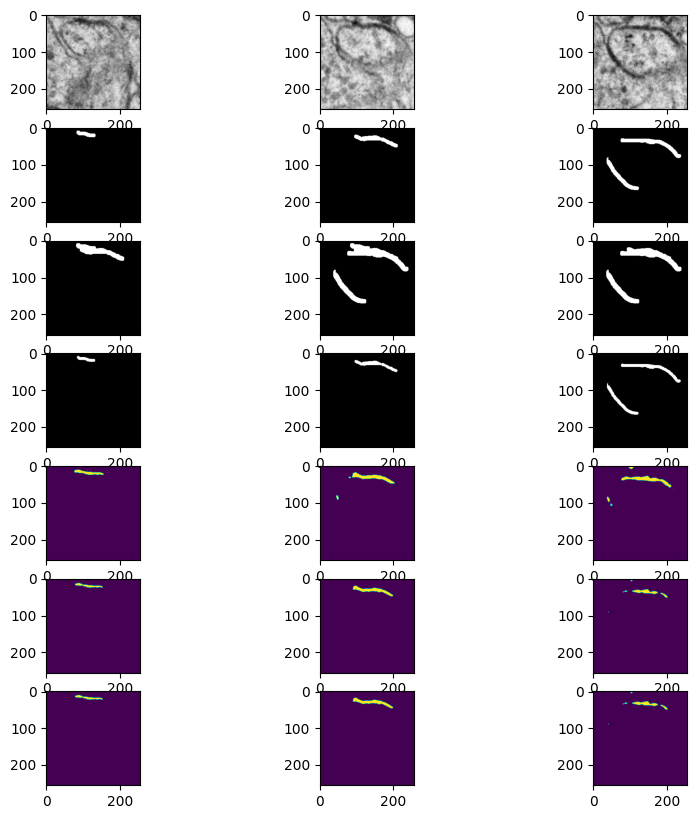

In [9]:
expanded_gt = expand_binary_mask_3d(mask[1], kernel_size=(3,3,3))
shrunk_gt = shrink_binary_mask_3d(mask[0], kernel_size=(1,3,3))
fig, ax = plt.subplots(7, depth, figsize=(10, 10))
visualize_3d_slice(img[0], ax[0])
visualize_3d_slice(mask[1], ax[1])
visualize_3d_slice(expanded_gt, ax[2])
visualize_3d_slice(shrunk_gt, ax[3])
visualize_3d_slice(pred_max, ax[4], cmap="viridis")
visualize_3d_slice(pred[0,1].detach(), ax[5], cmap="viridis")
visualize_3d_slice(pred_cutoff.detach(), ax[6], cmap="viridis")

torch.Size([3, 256, 256])


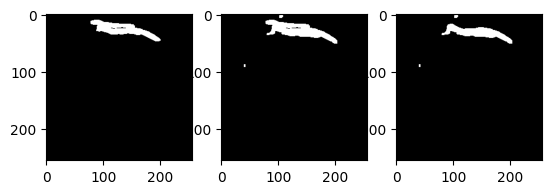

In [10]:
expanded_pred = expand_binary_mask_3d(pred_cutoff, kernel_size=(3,3,3))
print(expanded_pred.shape)
fig, ax = plt.subplots(1,3)
visualize_3d_slice(expanded_pred, ax)

In [38]:

import numpy as np
import matplotlib.pyplot as plt

def get_colored_image(image, color_map=None):
    # Define the default color map
    if color_map is None:
        color_map = {
            0: [0, 0, 0],  # Red (TN)
            1: [1, 0, 0],  # Green (FP) (pred only)
            2: [0, 0, 1],  # Blue (FN) (double_mask only)
            3: [1, 1, 1],  # Black (TP)
        }
    # Create an empty RGB image
    depth, height, width = image.shape
    colored_image = np.zeros((depth, height, width, 3), dtype=np.float32) 
    
    # Map the pixel values to the corresponding colors
    for value, color in color_map.items():
        colored_image[image == value] = color
    return colored_image

(array([0., 1., 2., 3.], dtype=float32), array([191134,    188,   3506,   1780]))


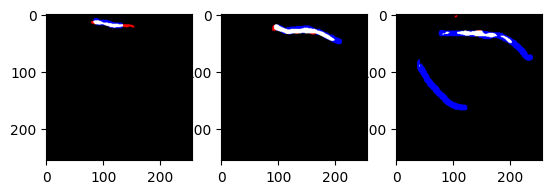

In [39]:
from matplotlib.colors import ListedColormap

combined_volume = np.asarray((mask[1] * 2 + pred_cutoff).detach())
color_combined_volume = _colored_image(combined_volume)
print(np.unique(combined_volume, return_counts=True))
# Define custom colors for each value
color_map = {
    0: [0, 0, 0],  # Red (TN)
    1: [1, 0, 0],  # Green (FP) (pred only)
    2: [0, 0, 1],  # Blue (FN) (double_mask only)
    3: [1, 1, 1],  # Black (TP)
}
# corresponds to [true negative, false positive, false negative, true positive]
# 0: no label, black
# 1: false positive (in prediction, not ground truth), red
# 2: false negative (in ground truth, not prediction), green
# 3: true positive (correct)

fig, ax = plt.subplots(1,3)
visualize_3d_slice(color_combined_volume, ax)

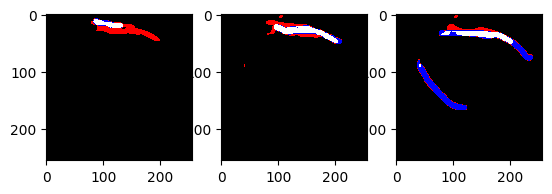

In [86]:
from matplotlib.colors import ListedColormap
combined_volume = np.asarray((mask[1] * 2 + expanded_pred).detach())
colors = ['black', 'red', 'blue', 'white']
cmap = ListedColormap(colors)
fig, ax = plt.subplots(1,3)
visualize_3d_slice(combined_volume, ax, cmap=cmap)

In [33]:
iou = get_iou(pred=pred_cutoff, target=mask[1])
accuracy = get_accuracy(pred=pred_cutoff, target=mask[1])
precision = get_precision(pred=pred_cutoff, target=mask[1])
recall = get_recall(pred=pred_cutoff, target=mask[1])
precision_generous = get_precision(pred=pred_cutoff, target=expanded_gt)
recall_generous = get_recall(pred=expanded_pred, target=mask[1])
tp, fp, tn, fn = get_confusion_matrix(pred=pred_cutoff, target=mask[1])
print(precision, precision_generous)
print(recall, recall_generous)

tensor(0.4978, grad_fn=<DivBackward0>) tensor(0.6234, grad_fn=<DivBackward0>)
tensor(0.4482, grad_fn=<DivBackward0>) tensor(0.6810)


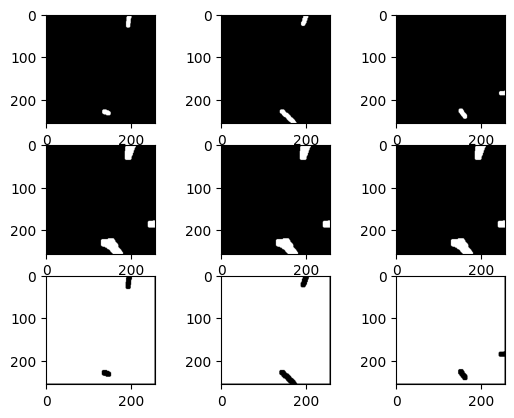

In [66]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
total_accuracy = 0
total_precision = 0
total_recall = 0
total_iou = 0
total_tp = 0
total_fp = 0
total_tn = 0
total_fn = 0
# num_samples = 3
num_samples = len(valid_dataset)

for i in range(num_samples):
    # get prediction
    image, mask = valid_dataset[i] # (channels, depth, height, width)
    image, mask = image.to(DEVICE), mask.to(DEVICE)
    intermediate_pred, pred = model(image)
    pred = torch.argmax(pred[0], dim=0) # (depth, height, width)
    
    # calculate the metrics
    iou = get_iou(pred=pred, target=mask[1])
    accuracy = get_accuracy(pred=pred, target=mask[1])
    precision = get_precision(pred=pred, target=mask[1])
    recall = get_recall(pred=pred, target=mask[1])
    tp, fp, tn, fn = get_confusion_matrix(pred=pred, target=mask[1])
    total_accuracy += accuracy
    total_precision += precision
    total_recall += recall
    total_iou += iou
    total_tp += tp
    total_fp += fp
    total_tn += tn
    
    # save the results
    fig, ax = plt.subplots(3, 5, figsize=(15, 5), num=f"valid_{i}")
    visualize_3d_slice(image[0], ax[0], "Input")
    visualize_3d_slice(mask[0], ax[1], "Label")
    visualize_3d_slice(pred, ax[2], "Prediction")
    plt.savefig(f"{results_dir}/valid_{i}.png")
    plt.close("all")
    
    print(f"TP = {tp}, FP = {fp}, TN = {tn}, FN = {fn}")
    print(f"Valid {i}: accuracy={accuracy:.4f}, precision={precision:.4f}, recall={recall:.4f}, iou={iou:.4f} | progress: {100*(i+1)/num_samples:.2f}%")
avg_accuracy = total_accuracy / num_samples
avg_precision = total_precision / num_samples
avg_recall = total_recall / num_samples
avg_iou = total_iou / num_samples
avg_tp = total_tp / num_samples
avg_fp = total_fp / num_samples
avg_tn = total_tn / num_samples
avg_fn = total_fn / num_samples
print(f"AVERAGE accuracy: {avg_accuracy:.4f}, precision: {avg_precision:.4f}, recall: {avg_recall:.4f}, iou: {avg_iou:.4f}")


TP = 0.0, FP = 0.0, TN = 0.0, FN = 20480.0
Valid 0: accuracy=1.0, precision=1.0, recall=1.0, iou=1.0 | progress: 12.50%
TP = 0.0, FP = 0.0, TN = 0.0, FN = 20480.0
Valid 1: accuracy=1.0, precision=1.0, recall=1.0, iou=1.0 | progress: 25.00%
TP = 239.0, FP = 19.0, TN = 204.0, FN = 20018.0
Valid 2: accuracy=0.9891113042831421, precision=0.9263566136360168, recall=0.5395033955574036, iou=0.5173160433769226 | progress: 37.50%
TP = 0.0, FP = 0.0, TN = 9.0, FN = 20471.0
Valid 3: accuracy=0.999560534954071, precision=1.0, recall=1.111110989882036e-07, iou=1.111110989882036e-07 | progress: 50.00%
TP = 0.0, FP = 0.0, TN = 0.0, FN = 20480.0
Valid 4: accuracy=1.0, precision=1.0, recall=1.0, iou=1.0 | progress: 62.50%
TP = 0.0, FP = 0.0, TN = 0.0, FN = 20480.0
Valid 5: accuracy=1.0, precision=1.0, recall=1.0, iou=1.0 | progress: 75.00%
TP = 0.0, FP = 0.0, TN = 0.0, FN = 20480.0
Valid 6: accuracy=1.0, precision=1.0, recall=1.0, iou=1.0 | progress: 87.50%
TP = 0.0, FP = 0.0, TN = 0.0, FN = 20480.0
Va

In [49]:
iou = get_iou(pred=pred, target=mask[1])
accuracy = get_accuracy(pred=pred, target=mask[1])
precision = get_precision(pred=pred, target=mask[1])
recall = get_recall(pred=pred, target=mask[1])
tp, fp, tn, fn = get_confusion_matrix(pred=pred, target=mask[1])
print(f"IoU: {iou}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")
print(f"TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")

IoU: 1.0, Accuracy: 1.0, Precision: 1.0, Recall: 1.0
TP: 0.0, FP: 0.0, TN: 0.0, FN: 20480.0


torch.Size([1, 5, 256, 256]) torch.Size([2, 5, 256, 256])


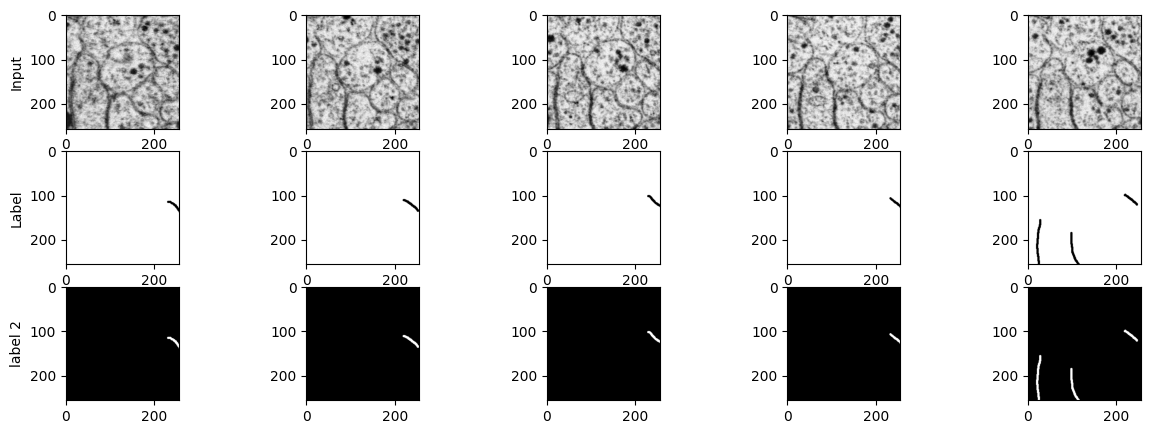

In [16]:
from utilities import visualize_3d_slice
import matplotlib.pyplot as plt
k = 4
inputs, labels = valid_dataset[k]
print(inputs.shape, labels.shape)


In [17]:
print(inputs.shape, labels.shape)

torch.Size([1, 5, 256, 256]) torch.Size([2, 5, 256, 256])


In [18]:
torch.sum(labels[1])

tensor(1987.)

In [19]:
np.unique(labels[0, 1].numpy(), return_counts=True)

(array([0., 1.], dtype=float32), array([  250, 65286]))

In [20]:
# takes ~ 30s to run
pred_2d, pred = model(inputs)

In [21]:
pred.shape, pred_2d.shape

(torch.Size([1, 2, 5, 256, 256]), torch.Size([1, 2, 5, 256, 256]))

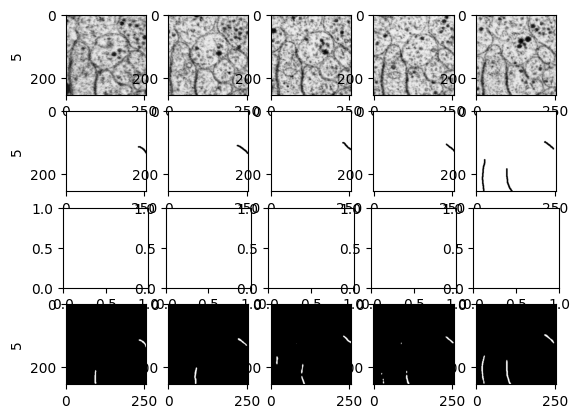

In [22]:
from utilities import *
input_img = inputs[0].numpy()
label_img = labels[0].numpy()
# pred_img = pred[0, 1].detach().numpy()
pred_binary = torch.argmax(pred, dim=1).numpy()[0]
depth, height, width = input_img.shape
fig, ax = plt.subplots(4, depth)
visualize_3d_slice(input_img, ax[0], depth)
visualize_3d_slice(label_img, ax[1], depth)
# visualize_3d_slice(pred_img, ax[2], depth)
visualize_3d_slice(pred_binary, ax[3], depth)

In [15]:
np.unique(pred_binary, return_counts=True)

(array([0]), array([327680]))